In [ ]:
# import zipfile
# with zipfile.ZipFile('kaggle/input/coco-data/imgs_filtered-20240730T090216Z-001', 'r') as zip_ref:
# zip_ref.extractall()

In [1]:
!pip install pycocotools
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.5 MB/s eta 0:00:00a 0:00:01m


In [2]:
import cv2
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import random
import skimage.io as io

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T

import torchvision.transforms as transforms
from torchsummary import summary

import math
from tqdm import tqdm

In [3]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Paths to annotation files
coco_train_inst_ann_file = "//kaggle/input/data-coco/instances_train2017.json"
coco_train_caps_ann_file = "/kaggle/input/data-coco/captions_train2017.json"
coco_val_inst_ann_file = "//kaggle/input/data-coco/instances_val2017.json"
coco_val_caps_ann_file = "//kaggle/input/data-coco/captions_val2017.json"

# Directory paths (in Colab working directory)
train_img_dir = '/kaggle/input/data-coco/imgs_filtered-20240730T090216Z-001/imgs_filtered'
val_img_dir = '/kaggle/input/data-coco/imgs_filtered-20240730T091123Z-001/imgs_filtered'
# filtered_train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/imgs_filtered'
# filtered_val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/imgs_filtered'

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

loading annotations into memory...
Done (t=24.52s)
creating index...
index created!
loading annotations into memory...
Done (t=2.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [5]:
# Define transformations
augmentations = T.Compose([
    T.RandomHorizontalFlip(),  # randomly flip horizontally
    T.RandomRotation(10),  # randomly rotate by 10 degrees
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # random affine transformations
])

# Define the combined transformation for training data
train_transform = T.Compose([
    augmentations,
    T.ToTensor(),  # transform to tensor, brings pixels to range (0, 1)
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalize to range (-1, 1) for all three channels
])

# For validation, we only resize and convert to tensor
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [6]:
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, coco, coco_caps, img_ids, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco = coco
        self.coco_caps = coco_caps
        self.transform = transform

        if max_samples:
            self.img_ids = img_ids[:max_samples]
        else:
            self.img_ids = img_ids

        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [7]:
# Define max_samples (optional)
# max_samples = 2000


# Map id to downloaded images
downloaded_train_imgs = set(os.listdir(train_img_dir))
downloaded_val_imgs = set(os.listdir(val_img_dir))

train_img_ids = []
for img_info in coco_train.dataset['images']:
    if img_info['file_name'] in downloaded_train_imgs:
        train_img_ids.append(img_info['id'])
        
val_img_ids = []
for img_info in coco_val.dataset['images']:
    if img_info['file_name'] in downloaded_val_imgs:
        val_img_ids.append(img_info['id'])


# Initialize data sets
try:
    coco_train_dataset = CocoCountDataset(
        img_dir=train_img_dir,
        coco=coco_train,
        coco_caps=coco_train_caps,
        img_ids=train_img_ids,
        transform=train_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of training images: {len(coco_train_dataset)}")

    coco_val_dataset = CocoCountDataset(
        img_dir=val_img_dir,
        coco=coco_val,
        coco_caps=coco_val_caps,
        img_ids=val_img_ids,
        transform=val_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of validation images: {len(coco_val_dataset)}")

except ValueError as e:
    print(e)

Number of training images: 5224
Number of validation images: 1071


In [29]:
# file_set = (set(os.listdir("/kaggle/input/ox-data/imgs_filtered-20240731T120956Z-001/imgs_filtered")))
# sorted_files = sorted(file_set, key=lambda x: int(os.path.splitext(x)[0]))
# sorted_files

In [8]:
oxford_annotations = pd.read_csv('/kaggle/input/ox-data/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])

data = oxford_annotations.drop(['headNumber','personNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'bodyLeft',
                  'bodyTop','bodyRight','bodyBottom','headBottom'], axis='columns')

count_data = data.drop_duplicates(subset='frameNumber', keep='first')

frame_counts = data['frameNumber'].value_counts(sort = False).reset_index()
frame_counts.columns = ['frameNumber', 'count']

count_data = count_data.merge(frame_counts, on='frameNumber')

# Split the data into training and validation sets
train_frame_counts, val_frame_counts = train_test_split(count_data, test_size=0.2, random_state=42)

In [9]:
class oxfordDataset(Dataset):
    def __init__(self, data_dir, frame_counts, transform=None, exclude_frame=None):
        self.data_dir = data_dir
        self.data = frame_counts
        self.transform = transform
        self.exclude_frame = exclude_frame  # Frame number to exclude

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data.iloc[idx]
        img_filename = f"{img_info['frameNumber']}.jpg"  # Assuming image filenames are like '0000.jpg', '0001.jpg', etc.

        # Skip the damaged image
        if self.exclude_frame is not None and img_info['frameNumber'] == self.exclude_frame:
            return self.__getitem__((idx + 1) % len(self.data))  # Get the next item (wrap around if necessary)

        img_path = os.path.join(self.data_dir, img_filename)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            return self.__getitem__((idx + 1) % len(self.data))  # Skip if file is not found or is damaged

        count = img_info['count']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)


In [10]:
# Initialize the second dataset

ox_img = "/kaggle/input/ox-data/imgs_filtered-20240731T120956Z-001/imgs_filtered"
ox_train_dataset = oxfordDataset(data_dir=ox_img, frame_counts=train_frame_counts, transform=train_transform, exclude_frame=1134)
ox_val_dataset = oxfordDataset(data_dir=ox_img, frame_counts=val_frame_counts, transform=val_transform, exclude_frame=1134)

# Combine datasets
train_combined_dataset = ConcatDataset([coco_train_dataset, ox_train_dataset])
val_combined_dataset = ConcatDataset([coco_val_dataset, ox_val_dataset])

# Create data loaders
train_loader = DataLoader(train_combined_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=16, shuffle=False)

In [11]:
# Check the lengths of individual datasets
print(f"Length of COCO train dataset: {len(coco_train_dataset)}")
print(f"Length of Oxford train dataset: {len(ox_train_dataset)}")

# Check the length of the combined dataset
print(f"Length of Combined train dataset: {len(train_combined_dataset)}")

Length of COCO train dataset: 5224
Length of Oxford train dataset: 2472
Length of Combined train dataset: 7696


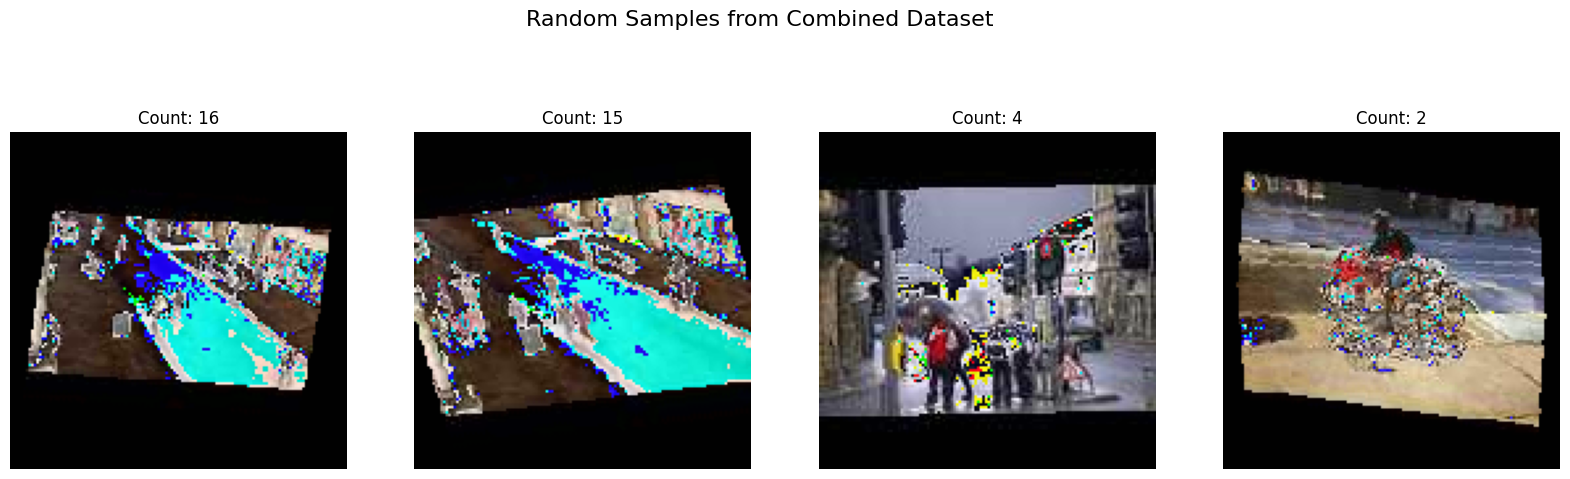

In [12]:
# Visualize random images from combined data set
def visualize_random_samples(dataset, num_samples=5):
    # Get a list of indices
    indices = random.sample(range(len(dataset)), num_samples)

    # Set up the figure and axes
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 6))
    fig.suptitle('Random Samples from Combined Dataset', fontsize=16)

    for i, idx in enumerate(indices):
        img, count = dataset[idx]

        # Convert tensor to PIL image for visualization
        img = T.ToPILImage()(img)

        # Plot image
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Count: {int(count.item())}')

    plt.show()

# Visualize random samples from the combined training dataset
visualize_random_samples(train_combined_dataset, num_samples=4)

# Optionally visualize random samples from the combined validation dataset
# visualize_random_samples(val_combined_dataset, num_samples=5)

In [13]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Adjust the number of filters
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32  # Reduce the initial number of channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
summary(cnn_model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             864
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           4,608
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
            Conv2d-7         [-1, 32, 512, 512]           4,608
       BatchNorm2d-8         [-1, 32, 512, 512]              64
              ReLU-9         [-1, 32, 512, 512]               0
       BasicBlock-10         [-1, 32, 512, 512]               0
           Conv2d-11         [-1, 16, 512, 512]           4,608
      BatchNorm2d-12         [-1, 16, 512, 512]              32
             ReLU-13         [-1, 16, 512, 512]               0
           Conv2d-14         [-1, 32, 5

In [15]:
def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]

                optimizer.zero_grad()
                output = model(data)  # Get the model output
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                pbar.update(1)

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]
                output = model(data)  # Get the model output
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

In [ ]:
# set hyperparameters
epochs = 100
patience = 15
lr = 0.0002
reg = 0.0001

criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

# training the model
train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, val_loader, early_stopper)

# plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100:  16%|█▋        | 79/481 [00:10<00:49,  8.08batch/s]

In [65]:
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, count in data_loader:
            images, count = images.to(device), count.to(device)
            output = model(images)
            y_preds.extend(output.cpu().numpy())
            y_true.extend(count.cpu().numpy())

    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return mae, mse, rmse, r2

evaluate_model(val_loader, cnn_model)

Mean Absolute Error (MAE): 2.3660
Mean Squared Error (MSE): 9.7420
Root Mean Squared Error (RMSE): 3.1212
R-squared (R2): 0.7707


(2.3660061, 9.742044, 3.1212249, 0.7706952933650113)

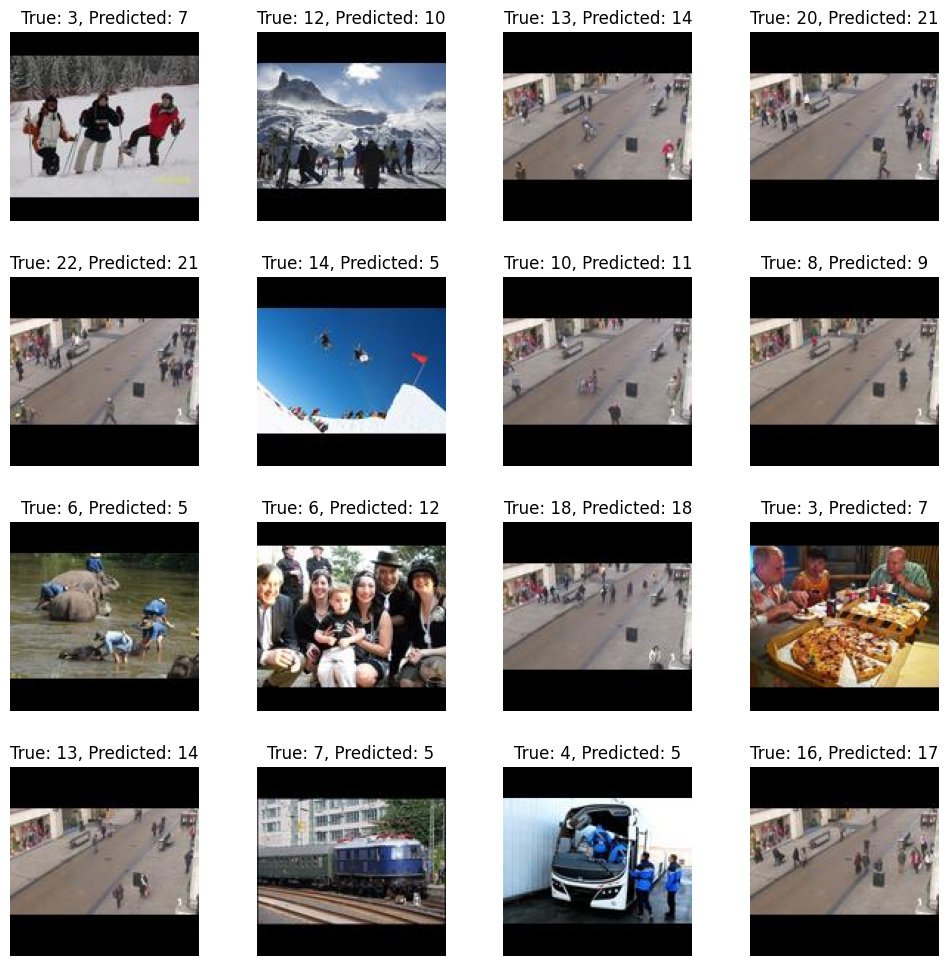

In [64]:
def visualize_prediction(model, dataset, number_of_images):
    model.eval()

    random_indices = random.sample(range(len(dataset)), number_of_images)

    # Calculate grid size
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  # Adjust figure size based on rows
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, idx in enumerate(random_indices):
        image, true_count = dataset[idx]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            predicted_count = model(image_tensor)  # Assume model returns a single output
            predicted_count = torch.round(predicted_count).item()  # Round and convert to scalar
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * 0.5 + 0.5

            if rows == 1 and cols == 1:
                ax = axes
            elif rows == 1 or cols == 1:
                ax = axes[i]
            else:
                ax = axes[i // cols, i % cols]

            ax.imshow(image_np)
            ax.set_title(f"True: {int(true_count)}, Predicted: {int(predicted_count)}")
            ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, val_combined_dataset, number_of_images=16)